## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk
import numpy as np
import pandas as pd
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import math
import matplotlib.pyplot as plt
import seaborn as sns
# supress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [6]:
#taking 3 sents.
nltk_data[:3]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')],
 [('Rudolph', 'NOUN'),
  ('Agnew', 'NOUN'),
  (',', '.'),
  ('55', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  ('and', 'CONJ'),
  ('former', 'ADJ'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Consolidated', 'NOUN'),
  ('Gold', 'NOUN'),
  ('Fields', 'NOUN'),
  ('PLC', 'NOUN'),
  (',', '.'),
  ('was', 'VERB'),
  ('named', 'VERB'),
  ('*-1', 'X'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
 

In [7]:
# converting the list of sent's to a list of (word, pos tag) tuples
tagged_words = [tup for sent in nltk_data for tup in sent]
print(len(tagged_words))
tagged_words[:10]

100676


[('Pierre', 'NOUN'),
 ('Vinken', 'NOUN'),
 (',', '.'),
 ('61', 'NUM'),
 ('years', 'NOUN'),
 ('old', 'ADJ'),
 (',', '.'),
 ('will', 'VERB'),
 ('join', 'VERB'),
 ('the', 'DET')]

In [8]:
#set the random seed
random.seed(1234)

#Divide the data into training and test sets
train_set, val_set = train_test_split(nltk_data,train_size=.95)

#Get the length of training and test sets
print(len(train_set))
print(len(val_set))

3718
196


In [9]:
#list of tagged words in train set
train_tag_words = [tup for sent in train_set for tup in sent]
#Get the length of the total tagged words in training set
len(train_tag_words)

95403

In [10]:
#looking first 10 tokens in the train set
tokens = [pair[0] for pair in train_tag_words]
tokens[:10]

['Criminal',
 'charges',
 '*ICH*-2',
 'were',
 'filed',
 '*-1',
 'against',
 'Diceon',
 'Electronics',
 'Inc.']

In [11]:
#the total unique words in the train set
V = set(tokens)
print(len(V))

12046


In [12]:
#no. of pos tags in the train corpus
T = set([pair[1] for pair in train_tag_words])
print(len(T))
print(T)

12
{'ADJ', 'ADP', 'PRT', 'VERB', 'NOUN', '.', 'ADV', 'X', 'CONJ', 'NUM', 'PRON', 'DET'}


In [13]:
# 12 tags which is already a part of universal tagset.

### Build the vanilla Viterbi based POS tagger

In [14]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [15]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tag_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [18]:
#checking emission probabilities.
print("\n", "charges")
print(word_given_tag('charges', 'ADJ'))
print(word_given_tag('charges', 'VERB'))
print(word_given_tag('charges', 'NOUN'), "\n")


 charges
(0, 6027)
(2, 12882)
(15, 27388) 



In [19]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tag_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [21]:
#checking transition probabilities
print(t2_given_t1(t2='ADP', t1='ADJ'))
print(t2_given_t1('NOUN', 'ADJ'))
print(t2_given_t1('NOUN', 'DET'))
print(t2_given_t1('ADV', 'VERB'))

(468, 6027)
(4219, 6027)
(5277, 8261)
(1067, 12882)


In [846]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [847]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df

,PRON,ADJ,.,NUM,NOUN,CONJ,X,DET,VERB,ADV,ADP,PRT
PRON,0.008127,0.073142,0.040635,0.007353,0.208204,0.004644,0.094040,0.009675,0.485294,0.034056,0.022833,0.011997
ADJ,0.000660,0.066028,0.063717,0.020304,0.700561,0.017002,0.020634,0.004952,0.011885,0.004787,0.078244,0.011225
.,0.065032,0.043744,0.093057,0.080841,0.223031,0.058385,0.026498,0.174616,0.088566,0.052816,0.090901,0.002425
NUM,0.001485,0.032383,0.119430,0.183601,0.354427,0.013369,0.209150,0.003268,0.017528,0.002971,0.035651,0.026738
NOUN,0.004844,0.012164,0.239812,0.009724,0.264358,0.042827,0.029353,0.012819,0.147675,0.016825,0.175971,0.043629
CONJ,0.056865,0.116043,0.036523,0.041147,0.350439,0.000462,0.008784,0.119741,0.154877,0.055479,0.055016,0.004623
X,0.055600,0.016250,0.164410,0.002868,0.061494,0.010355,0.075195,0.055440,0.202485,0.025490,0.145770,0.184642
DET,0.003498,0.204800,0.017368,0.021831,0.639247,0.000362,0.045471,0.005789,0.039682,0.012182,0.009528,0.000241
VERB,0.035315,0.065585,0.035005,0.022586,0.110214,0.005511,0.218178,0.133188,0.168814,0.082738,0.091431,0.031434
ADV,0.014560,0.127399,0.135672,0.032098,0.031767,0.007280,0.023163,0.070483,0.347452,0.080079,0.116148,0.013898


In [848]:
tags_df.loc['.', :]

PRON    0.065032
ADJ     0.043744
.       0.093057
NUM     0.080841
NOUN    0.223031
CONJ    0.058385
X       0.026498
DET     0.174616
VERB    0.088566
ADV     0.052816
ADP     0.090901
PRT     0.002425
Name: ., dtype: float32

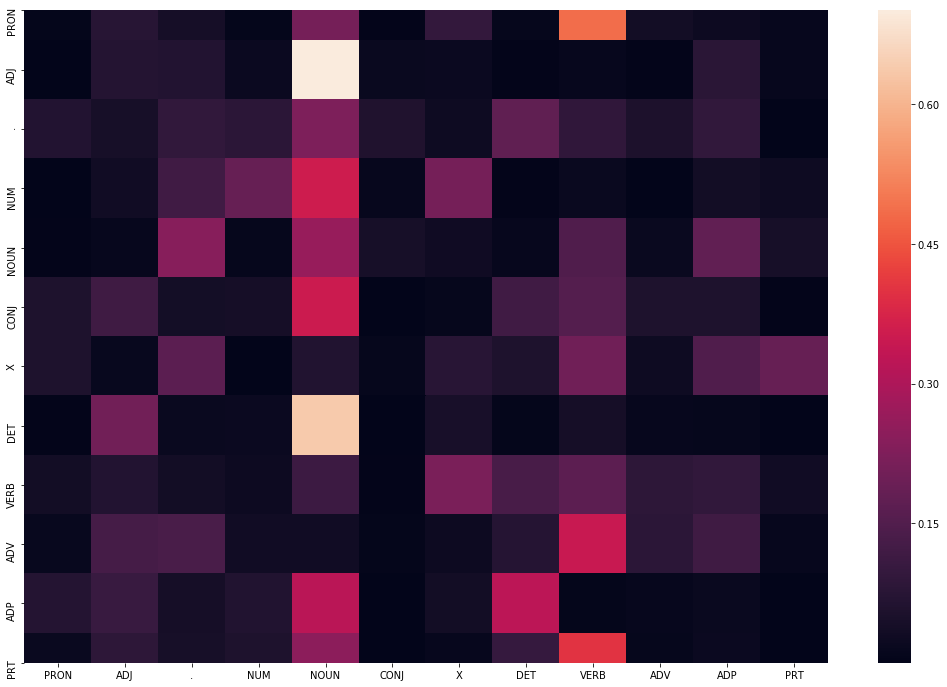

In [849]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()


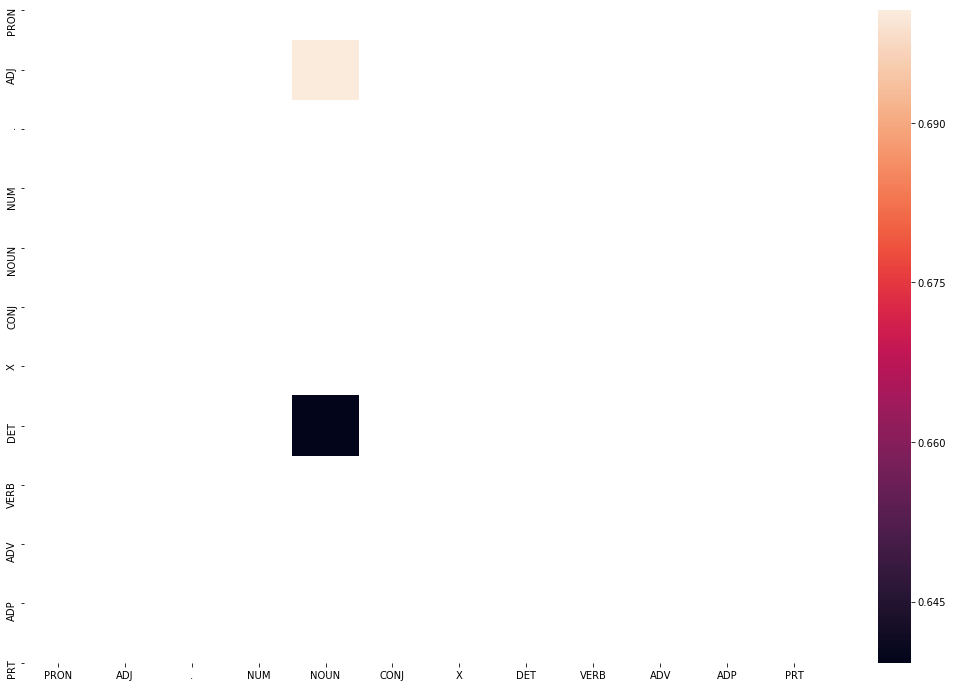

In [850]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

In [851]:
# from the heat it is clearly shown (NOUN and ADJ) and (NOUN and DET) are highly correlated.

In [852]:
#lenght of train tag words
len(train_tag_words)

95649

In [853]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tag_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))



In [854]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 10 sents
rndom = [random.randint(1,len(val_set)) for x in range(10)]# change range to 5

# list of sents
test_run = [val_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tag_words = [tup[0] for sent in test_run for tup in sent]
test_run


[[('The', 'DET'),
  ('new', 'ADJ'),
  ('ad', 'NOUN'),
  ('plan', 'NOUN'),
  ('from', 'ADP'),
  ('Newsweek', 'NOUN'),
  (',', '.'),
  ('a', 'DET'),
  ('unit', 'NOUN'),
  ('of', 'ADP'),
  ('the', 'DET'),
  ('Washington', 'NOUN'),
  ('Post', 'NOUN'),
  ('Co.', 'NOUN'),
  (',', '.'),
  ('is', 'VERB'),
  ('the', 'DET'),
  ('second', 'ADJ'),
  ('incentive', 'NOUN'),
  ('plan', 'NOUN'),
  ('0', 'X'),
  ('the', 'DET'),
  ('magazine', 'NOUN'),
  ('has', 'VERB'),
  ('offered', 'VERB'),
  ('advertisers', 'NOUN'),
  ('*T*-1', 'X'),
  ('in', 'ADP'),
  ('three', 'NUM'),
  ('years', 'NOUN'),
  ('.', '.')],
 [('RMS', 'NOUN'),
  ('distributes', 'VERB'),
  ('electronic', 'ADJ'),
  ('devices', 'NOUN'),
  ('and', 'CONJ'),
  ('produces', 'VERB'),
  ('power', 'NOUN'),
  ('supplies', 'NOUN'),
  ('and', 'CONJ'),
  ('plastic', 'ADJ'),
  ('literature', 'NOUN'),
  ('displays', 'NOUN'),
  ('.', '.')],
 [('Not', 'ADV'),
  ('that', 'ADP'),
  ('Washington', 'NOUN'),
  ('and', 'CONJ'),
  ('Tokyo', 'NOUN'),
  ('disagr

In [855]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tag_words)
end = time.time()
difference = end-start

In [856]:
print(difference)

84.74187111854553


In [857]:
# Get accuracy of model
#getting around 86% of accuracy with the default Viterbi algorithm.
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print(accuracy)

0.9109311740890689


In [858]:
#check for incorrect tagged words
incorrect_tag_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [859]:
incorrect_tag_cases

[[('Washington', 'NOUN'), (('Post', 'PRON'), ('Post', 'NOUN'))],
 [('RMS', 'NOUN'), (('distributes', 'PRON'), ('distributes', 'VERB'))],
 [('and', 'CONJ'), (('produces', 'PRON'), ('produces', 'VERB'))],
 [('power', 'NOUN'), (('supplies', 'VERB'), ('supplies', 'NOUN'))],
 [('plastic', 'ADJ'), (('literature', 'PRON'), ('literature', 'NOUN'))],
 [('literature', 'NOUN'), (('displays', 'PRON'), ('displays', 'NOUN'))],
 [('of', 'ADP'), (('unfettered', 'PRON'), ('unfettered', 'ADJ'))],
 [('.', '.'), (('First', 'NOUN'), ('First', 'ADJ'))],
 [('of', 'ADP'), (('prepayment', 'PRON'), ('prepayment', 'NOUN'))],
 [('rates', 'NOUN'), (('decline', 'NOUN'), ('decline', 'VERB'))],
 [('such', 'ADJ'), (('prepayment', 'PRON'), ('prepayment', 'NOUN'))],
 [('prepayment', 'NOUN'), (('forces', 'NOUN'), ('forces', 'VERB'))],
 [('to', 'PRT'), (('redeploy', 'PRON'), ('redeploy', 'VERB'))],
 [('from', 'ADP'), (('cyclical', 'PRON'), ('cyclical', 'ADJ'))],
 [('``', '.'), (('One', 'NUM'), ('One', 'NOUN'))],
 [('a', '

In [860]:
len(incorrect_tag_cases)

22

### Solve the problem of unknown words

In [861]:
#Read the text file using list
import codecs
test_line=[]
f = codecs.open("Test_sentences.txt", encoding='utf-8')
for line in f:
    print(line)
    test_line.append(line)

Android is a mobile operating system developed by Google.

Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.

Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.

Twitter is an online news and social networking service on which users post and interact with messages known as tweets.

Before entering politics, Donald Trump was a domineering businessman and a television personality.

The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.

This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.

Show me the cheapest round trips from Dallas to Atlanta

I would like to see flights from Denver to Philadelphia.

Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.

NASA invited social media users to experience the launch of ICESAT-2 Satelli

In [862]:
#getting sample test set
test_line

['Android is a mobile operating system developed by Google.\r\n',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.\r\n',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.\r\n",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.\r\n',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.\r\n',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.\r\n',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.\r\n',
 'Show me the cheapest round trips from Dallas to Atlanta\r\n',
 'I would like to see flights from Denver to Philadelphia.\r\n',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.\r\n',
 'NASA

In [863]:
#Strip the special characters and empty strings in the list file
test_string =[sent.strip() for sent in test_line if sent.strip()!='']
test_string

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

In [864]:
# predictions on the test sentences
sample_pred_list =[]
for line in test_string:
    sample_pred_list=sample_pred_list+list(Viterbi(word_tokenize(line)))
sample_pred_list

[('Android', 'PRON'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'PRON'),
 ('.', '.'),
 ('Android', 'PRON'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'PRON'),
 ('worldwide', 'PRON'),
 ('on', 'ADP'),
 ('smartphones', 'PRON'),
 ('since', 'ADP'),
 ('2011', 'PRON'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'PRON'),
 ('since', 'ADP'),
 ('2013', 'PRON'),
 ('.', '.'),
 ('Google', 'PRON'),
 ('and', 'CONJ'),
 ('Twitter', 'PRON'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'PRON'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'PRON'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'PRON'),
 ("'s", 'VERB'),
 ('firehose', 'PRON'),
 ('.', '.'),
 ('Twitter', 'PRON'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'PRON'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),


In [865]:
#from above text sentence there are words that is incorrectly by POS tags.

In [866]:
#the tokens in the test file
sample_words=[tokens for line in test_string for tokens in word_tokenize(line)]

In [867]:
#list of words which are present in test lines but not in the training corpus
words_not_in_corpus = list(set(sample_words) - set(tokens))
words_not_in_corpus


['OS',
 'Google',
 'Android',
 'NASA',
 'online',
 'Cup',
 'interact',
 'arriving',
 'smartphones',
 'Twitter',
 'personality',
 'worldwide',
 'firehose',
 'ICESAT-2',
 'tournament',
 'Satellite',
 '21st',
 'domineering',
 'invited',
 'trips',
 'contested',
 '2018',
 'messages',
 'tweets',
 '2011',
 '2015',
 '2013',
 'tablets',
 'FIFA']

In [868]:
len(words_not_in_corpus)

29

In [869]:
#the tags predicted for unknown words
[tup for tup in sample_pred_list for word in words_not_in_corpus if tup[0]==word ]

[('Android', 'PRON'),
 ('Google', 'PRON'),
 ('Android', 'PRON'),
 ('OS', 'PRON'),
 ('worldwide', 'PRON'),
 ('smartphones', 'PRON'),
 ('2011', 'PRON'),
 ('tablets', 'PRON'),
 ('2013', 'PRON'),
 ('Google', 'PRON'),
 ('Twitter', 'PRON'),
 ('2015', 'PRON'),
 ('Google', 'PRON'),
 ('Twitter', 'PRON'),
 ('firehose', 'PRON'),
 ('Twitter', 'PRON'),
 ('online', 'PRON'),
 ('interact', 'PRON'),
 ('messages', 'PRON'),
 ('tweets', 'PRON'),
 ('domineering', 'PRON'),
 ('personality', 'PRON'),
 ('2018', 'PRON'),
 ('FIFA', 'PRON'),
 ('Cup', 'PRON'),
 ('21st', 'PRON'),
 ('FIFA', 'PRON'),
 ('Cup', 'PRON'),
 ('tournament', 'PRON'),
 ('contested', 'PRON'),
 ('Cup', 'PRON'),
 ('trips', 'PRON'),
 ('arriving', 'PRON'),
 ('NASA', 'PRON'),
 ('invited', 'PRON'),
 ('ICESAT-2', 'PRON'),
 ('Satellite', 'PRON')]

In [870]:
#Let's count of all tags in the training set
from collections import Counter
tag_counts = Counter(pair[1] for pair in train_tag_words)
tag_counts

Counter({'NOUN': 27459,
         'VERB': 12884,
         'PRT': 3050,
         'DET': 8291,
         '.': 11133,
         'ADJ': 6058,
         'ADP': 9362,
         'X': 6277,
         'CONJ': 2163,
         'PRON': 2584,
         'ADV': 3022,
         'NUM': 3366})

In [871]:
# the most common tags can in the training corpus
tag_counts.most_common(5)

[('NOUN', 27459), ('VERB', 12884), ('.', 11133), ('ADP', 9362), ('DET', 8291)]

In [872]:
#Lets count the incorrectly classfied words for each tag
incorrect_tag_counts = Counter(pair[0][1] for pair in incorrect_tag_cases)
incorrect_tag_counts

Counter({'NOUN': 7,
         'CONJ': 1,
         'ADJ': 2,
         'ADP': 3,
         '.': 2,
         'PRT': 1,
         'DET': 3,
         'VERB': 1,
         'X': 2})

In [873]:
# Let check the percentage of verbs which are classifed as 'VERB' which end with 'ed'
#how many words with the tag 'VERB' (verb, past tense) ends with 'ed'
past_tense_verbs = [pair for pair in train_tag_words if pair[1]=='VERB']
ed_verbs = [pair for pair in past_tense_verbs if pair[0].endswith('ed')]
print(len(ed_verbs) / len(past_tense_verbs))
ed_verbs[:20]

0.20700093138776776


[('contributed', 'VERB'),
 ('produced', 'VERB'),
 ('received', 'VERB'),
 ('disclosed', 'VERB'),
 ('offered', 'VERB'),
 ('listed', 'VERB'),
 ('expected', 'VERB'),
 ('anticipated', 'VERB'),
 ('scheduled', 'VERB'),
 ('firmed', 'VERB'),
 ('faltered', 'VERB'),
 ('priced', 'VERB'),
 ('priced', 'VERB'),
 ('hampered', 'VERB'),
 ('closed', 'VERB'),
 ('expected', 'VERB'),
 ('negotiated', 'VERB'),
 ('followed', 'VERB'),
 ('discussed', 'VERB'),
 ('polarized', 'VERB')]

In [874]:
# around 20% of words which ends with 'ed' are verb.

In [875]:
# Let check the percentage of verbs which are classifed as 'VERB' which end with 'ing'
#how many words with the tag 'VERB' ends with 'ing'
participle_verbs = [pair for pair in train_tag_words if pair[1]=='VERB']
ing_verbs = [pair for pair in participle_verbs if pair[0].endswith('ing')]
print(len(ing_verbs) / len(participle_verbs))
ing_verbs[:20]

0.10734244023595156


[('according', 'VERB'),
 ('softening', 'VERB'),
 ('working', 'VERB'),
 ('proving', 'VERB'),
 ('lying', 'VERB'),
 ('acknowledging', 'VERB'),
 ('going', 'VERB'),
 ('increasing', 'VERB'),
 ('Performing', 'VERB'),
 ('becoming', 'VERB'),
 ('having', 'VERB'),
 ('encroaching', 'VERB'),
 ('choosing', 'VERB'),
 ('according', 'VERB'),
 ('finding', 'VERB'),
 ('addressing', 'VERB'),
 ('yielding', 'VERB'),
 ('enjoying', 'VERB'),
 ('being', 'VERB'),
 ('redeeming', 'VERB')]

In [876]:
#around 10% of words which are ends with 'ing' are verbs.

In [877]:
#Lets check the percentage of Adjective tags followed by NOUNS
# create a list of all tags (without the words)
tags = [pair[1] for pair in train_tag_words]

# create a list of Adj tags
adj_tags = [t for t in tags if t == 'ADJ']

# create a list of (ADJ, Noun) tags
adj_nn_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='ADJ' and tags[index+1]=='NOUN']

print(len(adj_tags))
print(len(adj_nn_tags))
print(len(adj_nn_tags) / len(adj_tags))

6058
4244
0.7005612413337735


In [878]:
#around 70% of adj's are followed by noun's.

In [879]:
#Lets check the percentage of Determinent tags followed by NOUN's
dt_tags = [t for t in tags if t == 'DET']
dt_nn_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='DET' and tags[index+1]=='NOUN']

print(len(dt_tags))
print(len(dt_nn_tags))
print(len(dt_nn_tags) / len(dt_tags))

8291
5300
0.6392473766735014


In [880]:
#around 64% of det's followed by noun'd

In [881]:
#Lets check the percentage of Adverbs tags followed by VERB's
md_tags = [t for t in tags if t == 'ADV']
md_vb_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='ADV' and tags[index+1]=='VERB']

print(len(md_tags))
print(len(md_vb_tags))
print(len(md_vb_tags) / len(md_tags))

3022
1050
0.34745201853077434


In [882]:
#around 34% of adverb's are followed by verb's.

### 1. Combining viterbi with n-gram tagging using BrillTagger

In [883]:
# specify Rule-Based regex patterns for tagging

patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense verbs
    (r'.*es$', 'VERB'),               # singular present verbs
    (r'.*ould$', 'VERB'),             # modal verbs
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'(The|the|A|a|An|an)$', 'DET'), # articles or determinants
    (r'.*able$', 'ADJ'),              # adjectives
    (r'.*ness$', 'NOUN'),             # nouns formed from adjectives
    (r'.*ly$', 'ADV'),                # adverbs
    (r'.*', 'NOUN')                   # nouns
]
    

In [884]:
# rule based Unigram tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

# lexicon backed up by the rule-based tagger
lexicon_tagger = nltk.UnigramTagger(train_set, backoff=rule_based_tagger)
#prediction on test set
lexicon_tagger.evaluate(val_set)

0.9443007758106227

In [885]:
# rule based Bigram tagger
#bigram_tagger = nltk.RegexpTagger(patterns)

# lexicon backed up by the rule-based tagger
lexicon_tagger2 = nltk.BigramTagger(train_set, backoff=lexicon_tagger)
#evaluation on test set
lexicon_tagger2.evaluate(val_set)

0.9488760692261786

In [886]:
# rule based Trigram tagger
#trigram_tagger = nltk.RegexpTagger(patterns)

# lexicon backed up by the rule-based tagger
lexicon_tagger3 = nltk.TrigramTagger(train_set, backoff=lexicon_tagger2)
#evaluation on test set
lexicon_tagger3.evaluate(val_set)

0.9476825144221206

In [887]:
#https://www.nltk.org/book/ch03.html
#http://www.nltk.org/book_1ed/ch05.html
#Trigram(t3) tagger backed by Bigram(t2) backed by Unigram(t1) which is backed by rule based tagger(t0)
t0 = nltk.RegexpTagger(patterns)
t1 = nltk.UnigramTagger(train_set, backoff=t0)
t2 = nltk.BigramTagger(train_set, backoff=t1)
t3 = nltk.TrigramTagger(train_set, backoff=t2)

In [888]:
# if unknown word is the first word of a sentence, use unigram probability
# if unknown word is the second word of a sentence, use bigram probability
# if unknown word is present in any other position of a sentence, use trigram probability

In [889]:
#BrillTagger Implementation
#https://docs.huihoo.com/nltk/0.9.5/api/nltk.tag.brill.BrillTaggerTrainer-class.html
#https://docs.huihoo.com/nltk/0.9.5/api/nltk.tag.api.TaggerI-class.html#tag
#https://stackoverflow.com/questions/32106090/nltk-brill-tagger-splitting-words

#### Evaluating tagging accuracy

In [890]:
#https://streamhacker.com/2008/12/03/part-of-speech-tagging-with-nltk-part-3/
#https://www.nltk.org/_modules/nltk/tag/brill_trainer.html
#http://www.nltk.org/_modules/nltk/tag/brill_trainer_orig.html
#https://www.nltk.org/api/nltk.tag.html
#Import libraries for brill
import nltk.tag
from nltk.tag import brill
from nltk.tag.brill import *
from nltk.tbl.template import Template
from nltk.tag import BrillTaggerTrainer

#Clear templates created in earlier tests
Template._cleartemplates()

#Return 37 templates taken from the pos tagging task of the fntbl distribution
templates = fntbl37()
 
#Train the Brill model using trigram state(t3)
trainer = BrillTaggerTrainer(t3, templates)
brill_tagger = trainer.train(train_set, max_rules=100, min_score=3)


Brill tagging is a kind of transformation-based learning. The general idea is very simple: guess the tag of each word, then go back and fix the mistakes. In this way, a Brill tagger successively transforms a bad tagging of a text into a better one. As with n-gram tagging, this is a supervised learning method, since we need annotated training data to figure out whether the tagger's guess is a mistake or not. However, unlike n-gram tagging, it does not count observations but compiles a list of transformational correction rules.
- The state probabilities for unknown words become zero and hence the Viterbi algorithm updates the unknown words by default with the first tag in the training set.

In [891]:
# Viterbi Heuristic
def Viterbi_updated(words, train_bag = train_tag_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
       
        #Check if state probability is zero
        if(pmax==0.0):
            #If state probability is zero i.e if the word is unknown it updates the tag based on the brill tagger
            state_max = brill_tagger.tag([word])[0][1]
        else:
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [892]:
# validation_set
# Let's test our Viterbi algorithm on a few sample sentences of validation set
random.seed(1234)

# choose random 10 sents
rndom1 = [random.randint(1,len(val_set)) for x in range(10)]#change range to 5

# list of sents
test_run1 = [val_set[i] for i in rndom]

# list of tagged words
test_run_base1 = [tup for sent in test_run1 for tup in sent]

# list of untagged words
test_tag_words1 = [tup[0] for sent in test_run1 for tup in sent]

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [893]:
#checking the test sentences with the updated Viterbi algorithm
start = time.time()
updated_tagged_seq1 = Viterbi_updated(test_tag_words1)
end = time.time()
difference = end-start
#Print total time taken to train the algorithm
print(difference)

93.31787919998169


In [894]:
# Checking the accuracy of the updated Viterbi algorithm
check = [i for i, j in zip(updated_tagged_seq1, test_run_base1) if i == j] 
accuracy = len(check)/len(updated_tagged_seq1)
accuracy

0.9554655870445344

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [895]:
#Let's print the test string with the original Viterbi algorithm
for line in test_string:
    print(list(Viterbi(word_tokenize(line))))

[('Android', 'PRON'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'PRON'), ('.', '.')]
[('Android', 'PRON'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'PRON'), ('worldwide', 'PRON'), ('on', 'ADP'), ('smartphones', 'PRON'), ('since', 'ADP'), ('2011', 'PRON'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'PRON'), ('since', 'ADP'), ('2013', 'PRON'), ('.', '.')]
[('Google', 'PRON'), ('and', 'CONJ'), ('Twitter', 'PRON'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'PRON'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'PRON'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'PRON'), ("'s", 'VERB'), ('firehose', 'PRON'), ('.', '.')]
[('Twitter', 'PRON'), ('is', 'VERB'), ('an', 'DET'), ('online', 'PRON'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'D

In [896]:
#Let's print the test string with the updated Viterbi algorithm
for line in test_string:
    print(list(Viterbi_updated(word_tokenize(line))))

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]
[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]
[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')]
[('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET')

#### Results
- Here Android, Google are unknown word incorrectly tagged in the original viterbi algorithm. In the updated viterbi algorithm they are correctly classified as 'NOUN'.
- 2011, 2015 are unknown word, incorrectly tagged in the orginal viterbi algorithm. In the updated viterbi algorithm they are correctly classified as 'NUM' as cardinal numbers.
- NASA, ICESAT-2 are unknown word incorrectly tagged in the orignal viterbi algorithm. In the updated viterbi algorithm they are correctly classified as 'NOUN'
- Domineering and messages are unknown word incorrectly tagged in the original viterbi algorithm. In the updated viterbi algorithm they are correctly tagged as 'VERB'

### 2. Combine viterbi with rule based tagging

In [897]:
def rule_based_tagger(word):

    # define regular expression patterns
    patterns = [
        (r'.*(ing|ed|es|ould)$', 'VERB'),
        (r'.*\'s$', 'NOUN'),
        (r'.*s$', 'NOUN'),
        (r'^[A-Z]+.*$', 'NOUN'),
        (r'^-?[0-9]+(.[0-9]+)?-?(.*)?$', 'NUM'),
        (r'.*', 'NOUN')  # nouns (default)
    ]

    # using nltk.RegexpTagger
    regexp_tagger = nltk.RegexpTagger(patterns)
    regex_tag = regexp_tagger.tag([word])
    
    return regex_tag[0][1]

In [898]:
def Viterbi_With_Regex(words, train_bag = train_tag_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                try:
                    transition_p = tags_df.loc[state[-1], tag]
                except:
                    transition_p = 0 # no previous state is found.
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        if pmax == 0.0 :
            #If state probability is zero i.e if the word is unknown it updates the tag based on the rule-based
            state_max = rule_based_tagger(word)
        else:
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 

        state.append(state_max)
    return list(zip(words, state))

In [899]:
# validation_set
# Let's test our Viterbi algorithm on a few sample sentences of validation set
random.seed(1234)

# choose random 10 sents
rndom2 = [random.randint(1,len(val_set)) for x in range(10)]#change range to 5.

# list of sents
test_run2 = [val_set[i] for i in rndom]

# list of tagged words
test_run_base2 = [tup for sent in test_run2 for tup in sent]

# list of untagged words
test_tag_words2 = [tup[0] for sent in test_run2 for tup in sent]

In [900]:
# tagging the test sentences with the updated Viterbi algorithm
start = time.time()
updated_tagged_seq2 = Viterbi_With_Regex(test_tag_words2)
end = time.time()
difference = end-start

In [901]:
#Print total time taken to train the algorithm
print(difference)

83.70660972595215


##### Accuracy for the updated Viterbi with rule-based algorithm

In [902]:
#Calculate the accuracy for the updated Viterbi with rule-based algorithm
check = [i for i, j in zip(updated_tagged_seq2, test_run_base2) if i == j] 
accuracy = len(check)/len(updated_tagged_seq2)
accuracy

0.951417004048583

#### Compare incorrectly tagged by original POS Tagger and got correctly by modify POS tagger using rule-based tagger

In [903]:
#Let's print the test string with the original Viterbi algorithm
for line in test_string:
    print(list(Viterbi(word_tokenize(line))))

[('Android', 'PRON'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'PRON'), ('.', '.')]
[('Android', 'PRON'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'PRON'), ('worldwide', 'PRON'), ('on', 'ADP'), ('smartphones', 'PRON'), ('since', 'ADP'), ('2011', 'PRON'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'PRON'), ('since', 'ADP'), ('2013', 'PRON'), ('.', '.')]
[('Google', 'PRON'), ('and', 'CONJ'), ('Twitter', 'PRON'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'PRON'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'PRON'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'PRON'), ("'s", 'VERB'), ('firehose', 'PRON'), ('.', '.')]
[('Twitter', 'PRON'), ('is', 'VERB'), ('an', 'DET'), ('online', 'PRON'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'D

In [904]:
#checking updated regex algorithm on Sample test set
for line in test_string:
    print(list(Viterbi_With_Regex(word_tokenize(line))))

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]
[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]
[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')]
[('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET')

### Results :
- Android and Google are correctly updated as NOUN.
- 2011, 2013, 2015 are correctly updated as NUM.
- Message, Domineering are correctly updated as VERB.